# Elaborate example of how to calculate with DiKErnel

This tutorial shows how to setup, run and analyse a DiKErnel calculation using the dikerosion python toolbox. It deals with:
1. [Specifying calculation input](#specify-calculation-input):
    - [Dike schematization](#dike-schematization)
    - [Hydrodynamic conditions](#hydrodynamic-input)
    - [Output locations](#specify-calculations-at-specific-locations) for calculations with various types of revetments
    - (Optional) [calculation settings](#specify-optional-calculation-settings)
3. [Create a calculator object](#) for DiKErnel calculations
2. Validating the specified input
3. Running the calculation
4. Visualizing the calculation results

<div class="alert alert-block alert-info">
<b>Not necessary:</b> The following code makes sure that also during development the toolbox can be adressed properly.
</div>

In [231]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))

# Specify calculation input
First we need to specify the dike schematization, hydrodynamic conditions and calculation types and settings that we would like to perform.

## Dike schematization
Let's start with the schematization of the dike profile and roughnesses. This requires us to import the following class:


In [232]:
from dikerosion.data import DikeSchematization

We can now define the profile and roughnesses. The DikeSchematization requires the following input:
- The orientation of the dike normal in degrees relative to north (in our case we pretend the dike is oriented exactly towards north).
- A list of x-positions (the cross-shore locations of the profile points).
- A list of z-positions, specifying the height of the dike at the x-positions.
- A list of roughnesses specifying the roughness for each stretch of dike profile. This list therefore by default has a length 1 item smaller than the lists that specify x-positions and z-positions.
- The (horizontal) x-position of the outer toe of the dike.
- The (horizontal) x-position of the outer crest of the dike.

Optionally we can define the following characteristic points:
- The (horizontal) x-position of the crest of the outer berm.
- The (horizontal) x-position of the notch of the outer berm.
- The (horizontal) x-position of the inner crest of the dike.
- The (horizontal) x-position of the inner toe of the dike.

In [233]:
x_positions = [0.0, 25.0, 35.0, 41.0, 45, 50, 60, 70]
z_positions = [-3, 0.0, 1.5, 1.7, 3.0, 3.1, 0, -1]
roughnesses = [1, 1, 0.75, 0.5, 0.8, 0.8, 0.8]
schematization = DikeSchematization(
    0.0, x_positions, z_positions, roughnesses, 25.0, 45.0
)
schematization.crest_outer_berm = 35.0
schematization.notch_outer_berm = 41.0
schematization.inner_crest = 50.0
schematization.inner_toe = 60.0

## Hydrodynamic input
Since we are generating our own data, we would like to use a package like numpy to make things easy.

In [234]:
import numpy

Now it's time to generate a hypothetical high water occurrence that could occur for our dike. Let's say we are interested in high discharge that lasts for 35 hours, so first we create 1000 time steps to specify this event.

In [235]:
time_steps = numpy.linspace(
    0.0, 126000.0, int(126000.0 / 1000.0), dtype=float, endpoint=True
)

We start with specifying a rising and falling water level during this period, with a minimum of 0.5 meter and an amplitude of 1.3 meters (same reference level as the z-positions of the [dike schematization](#dike-schematization)).

In [236]:
phase_water_levels = numpy.pi / 64.0
amplitude_water_levels = 1.3
minimum_water_level = 0.5
water_levels = (
    amplitude_water_levels
    * (1 - numpy.cos(time_steps[1:] / 1000.0 * phase_water_levels))
    + minimum_water_level
)

Similar to the water level time series, we now create a series that depicts the development of the wave heights (with a minimum wave height of 0.8m), wave periods (linearly increasing in tim) and wave angles (also linearly turning around the dike normal).

<div class="alert alert-block alert-warning">
<b>Warning:</b> Make sure to specify wave directions only between 0 and 360 degrees. DiKErnel does not allow a wave direction outside this range.
</div>

In [237]:
phase_wave_heights = numpy.pi / 64.0
ampltude_waves = 0.5
minimum_wave_height = 0.8
wave_heights = (
    ampltude_waves * (1 - numpy.cos(time_steps[1:] / 1000.0 * phase_wave_heights))
    + minimum_wave_height
)

wave_periods = 7.0 + time_steps[1:] / 1000.0 * 0.06

wave_directions = -20 + time_steps[1:] / 1000.0 * 0.5
wave_directions = [
   d + 360 if d < 0 else d - 360 if d > 360 else d for d in wave_directions
]

In order to construct the hydrodynamic input for running our calculation, we need to import another class from the dikerosion toolbox:

In [238]:
from dikerosion.data import HydrodynamicConditions

The hydrodynamic conditions can now be defined as.

In [239]:
hydrodynamic_conditions = HydrodynamicConditions(
    time_steps, water_levels, wave_heights, wave_periods, wave_directions
)

## Specify calculations at specific locations
DiKErnel allows you to specify each location where you would like to perform a calculation of the degration of the dike revetment. The result of that is a list with specified output locations of various types. The output locations have in common that they all have a specified (horizontal) x-position, a toplayer type and the initial amount of damage at the start of the calculation.

DiKErnel, and therefore also the toolbox, specifies 5 different types of calculations (represented by 5 different output location specification classes that can all occur in the same list):
- Grass wave impact (on the outer slope)
- Grass wave runup (on the outer slope)
- Asphalt cover (on the outer slope)
- natural stone cover (on the outer slope), at this moment limited to nordic stone cover.
- Grass overflow and wave overtopping (crest and inner slope)

To be able to specify these calculation/output locations, we first need to import both the classes needed for specification of the calculation locations as well as the class that enables us to specify the type of toplayer.

In [240]:
from dikerosion.data import (
    GrassWaveImpactOutputLocationSpecification,
    GrassWaveRunupOutputLocationSpecification,
    GrassOvertoppingOutputLocationSpecification,
    AsphaltOutputLocationSpecification,
    NordicStoneOutputLocationSpecification,
    TopLayerType,
)



Each of these classes have their own input. They have in common that it is necessary to specify the x-location as well as the type of toplayer (unless there is only one possible type of toplayer for that type of calculation). 

Below we first define a small function to construct one location to calculate overtopping and erosion of a grass cover at the crest or inner slope of a grass revetment with a closed sod.

In [241]:
def create_grass_overtopping_output_location_closed_sod(
    x: float, initial_damage: float = 0.0
) -> GrassOvertoppingOutputLocationSpecification:
    specification = GrassOvertoppingOutputLocationSpecification(
        x, TopLayerType.GrassClosedSod
    )
    specification.initial_damage = initial_damage
    return specification


This function can than be used to specify a list of output locations. The documentation of the function to create these classes (constructor) includes a description of all possible input variables. Next to that some specifications also have optional parameters that can be specified after creation.

In [242]:
output_locations = [
    NordicStoneOutputLocationSpecification(25.01, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(25.5, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(26.0, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(26.5, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(27.0, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(27.5, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(28.0, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(28.5, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(29.0, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(29.5, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(30.0, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(30.5, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(31.0, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(31.5, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(32.0, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(32.5, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(33.0, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(33.5, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(34.0, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(34.5, 0.28, 2.45),
    NordicStoneOutputLocationSpecification(34.9, 0.28, 2.45),
    AsphaltOutputLocationSpecification(35.1, 0.9, 64.0, 0.146, 5712.0),
    AsphaltOutputLocationSpecification(35.5, 0.9, 64.0, 0.146, 5712.0),
    AsphaltOutputLocationSpecification(36.0, 0.9, 64.0, 0.146, 5712.0),
    AsphaltOutputLocationSpecification(36.5, 0.9, 64.0, 0.146, 5712.0),
    AsphaltOutputLocationSpecification(37.0, 0.9, 64.0, 0.146, 5712.0),
    AsphaltOutputLocationSpecification(37.5, 0.9, 64.0, 0.146, 5712.0),
    AsphaltOutputLocationSpecification(38.0, 0.9, 64.0, 0.146, 5712.0),
    AsphaltOutputLocationSpecification(38.5, 0.9, 64.0, 0.146, 5712.0),
    AsphaltOutputLocationSpecification(39.0, 0.9, 64.0, 0.146, 5712.0),
    AsphaltOutputLocationSpecification(39.5, 0.9, 64.0, 0.146, 5712.0),
    AsphaltOutputLocationSpecification(40.0, 0.9, 64.0, 0.146, 5712.0),
    AsphaltOutputLocationSpecification(40.5, 0.9, 64.0, 0.146, 5712.0),
    AsphaltOutputLocationSpecification(40.9, 0.9, 64.0, 0.146, 5712.0),
    GrassWaveImpactOutputLocationSpecification(41.1, TopLayerType.GrassClosedSod),
    GrassWaveImpactOutputLocationSpecification(41.5, TopLayerType.GrassClosedSod),
    GrassWaveImpactOutputLocationSpecification(42.0, TopLayerType.GrassClosedSod),
    GrassWaveImpactOutputLocationSpecification(42.5, TopLayerType.GrassClosedSod),
    GrassWaveImpactOutputLocationSpecification(43.0, TopLayerType.GrassClosedSod),
    GrassWaveImpactOutputLocationSpecification(43.5, TopLayerType.GrassClosedSod),
    GrassWaveImpactOutputLocationSpecification(44.0, TopLayerType.GrassOpenSod),
    GrassWaveImpactOutputLocationSpecification(44.5, TopLayerType.GrassOpenSod),
    GrassWaveImpactOutputLocationSpecification(44.99, TopLayerType.GrassClosedSod),
    GrassWaveRunupOutputLocationSpecification(
        41.5, 0.3, TopLayerType.GrassClosedSod
    ),
    GrassWaveRunupOutputLocationSpecification(
        42.0, 0.3, TopLayerType.GrassClosedSod
    ),
    GrassWaveRunupOutputLocationSpecification(
        42.5, 0.3, TopLayerType.GrassClosedSod
    ),
    GrassWaveRunupOutputLocationSpecification(
        41.1, 0.3, TopLayerType.GrassClosedSod
    ),
    GrassWaveRunupOutputLocationSpecification(
        43.0, 0.3, TopLayerType.GrassClosedSod
    ),
    GrassWaveRunupOutputLocationSpecification(
        43.5, 0.3, TopLayerType.GrassClosedSod
    ),
    GrassWaveRunupOutputLocationSpecification(44.0, 0.3, TopLayerType.GrassOpenSod),
    GrassWaveRunupOutputLocationSpecification(44.5, 0.3, TopLayerType.GrassOpenSod),
    GrassWaveRunupOutputLocationSpecification(
        44.99, 0.3, TopLayerType.GrassClosedSod
    ),
    create_grass_overtopping_output_location_closed_sod(45.0, 0.02),
    create_grass_overtopping_output_location_closed_sod(45.5, 0.02),
    create_grass_overtopping_output_location_closed_sod(46.0, 0.02),
    create_grass_overtopping_output_location_closed_sod(46.5, 0.02),
    create_grass_overtopping_output_location_closed_sod(47.0, 0.02),
    create_grass_overtopping_output_location_closed_sod(47.5, 0.02),
    create_grass_overtopping_output_location_closed_sod(48.0, 0.02),
    create_grass_overtopping_output_location_closed_sod(48.5, 0.02),
    create_grass_overtopping_output_location_closed_sod(49.0, 0.02),
    create_grass_overtopping_output_location_closed_sod(49.5, 0.02),
    create_grass_overtopping_output_location_closed_sod(49.99, 0.02),
    create_grass_overtopping_output_location_closed_sod(52.0, 0.02),
    create_grass_overtopping_output_location_closed_sod(54.0, 0.02),
    create_grass_overtopping_output_location_closed_sod(56.0, 0.02),
    create_grass_overtopping_output_location_closed_sod(58.0, 0.02),
]


## Specify optional calculation settings
Next to the location specific input and schematization of the dike profile and hydrodynamics, it is also possible to specify settings (mostly constants or factors) for the various types of calculations. Mostly these are not bound to a specific location. The toolbox contains classes for each type of calculation that can be used to specify calculation settings. In case these are not specified, DiKErnel will use its internal default values (denoted in the documentation of DiKErnel).

Each of the classes have in common that:
- They specify the calculation type for which the settings should be used.
- The failure number is specified (at which level of damage is the revetment considered as failed)
- They hold a collection of settings per type of toplayer (for example to make a distinction between closed sod and open sod)

To facilitate specification calculation settings for the various types of toplayer, the toolbox also contains classes for each toplayer type.

Before we can specify the optional calculation settings, we first need to import the relevant classes:

In [243]:
from dikerosion.data import (
    AsphaltCalculationSettings,
    NaturalStoneCalculationSettings,
    GrassWaveImpactCalculationSettings,
    GrassWaveOvertoppingCalculationSettings,
    CalculationMethod,
    NaturalStoneTopLayerSettings,
    AsphaltTopLayerSettings,
    GrasCoverCumulativeOverloadTopLayerSettings,
    GrassCoverWaveImpactTopLayerSettings,
)



Below code presents a method(/function) that specifies calculation settings for calculations on an asphalt cover layer.

In [244]:
def get_asphalt_calculation_settings() -> AsphaltCalculationSettings:
    top_layer = AsphaltTopLayerSettings()
    top_layer.stiffness_ratio_nu = 0.35
    top_layer.fatigue_asphalt_alpha = 0.5
    top_layer.fatigue_asphalt_beta = 5.4

    settings = AsphaltCalculationSettings([top_layer])
    settings.density_of_water = 1000.0
    settings.factor_ctm = 1.0
    settings.impact_number_c = 1.0
    settings.width_factors = [
        [0.1, 0.0392],
        [0.2, 0.0738],
        [0.3, 0.1002],
        [0.4, 0.1162],
        [0.5, 0.1213],
        [0.6, 0.1168],
        [0.7, 0.1051],
        [0.8, 0.089],
        [0.9, 0.0712],
        [1.0, 0.0541],
        [1.1, 0.0391],
        [1.2, 0.0269],
        [1.3, 0.0216],
        [1.4, 0.015],
        [1.5, 0.0105],
    ]
    settings.depth_factors = [
        [-1.0, 0.005040816326530646],
        [-0.9744897959183674, 0.00596482278562177],
        [-0.9489795918367347, 0.007049651822326582],
        [-0.923469387755102, 0.008280657034496978],
        [-0.8979591836734694, 0.009643192019984783],
        [-0.8724489795918368, 0.011122610376641823],
        [-0.846938775510204, 0.012704265702320014],
        [-0.8214285714285714, 0.014373511594871225],
        [-0.7959183673469388, 0.016115701652147284],
        [-0.7704081632653061, 0.017916189471999994],
        [-0.7448979591836735, 0.019760328652281334],
        [-0.7193877551020409, 0.02163347279084307],
        [-0.6938775510204082, 0.02352097548553716],
        [-0.6683673469387754, 0.025408190334215378],
        [-0.6428571428571429, 0.027280470934729583],
        [-0.6173469387755102, 0.029123170884931715],
        [-0.5918367346938775, 0.030921643782673508],
        [-0.5663265306122449, 0.03266124322580695],
        [-0.5408163265306123, 0.034327322812183814],
        [-0.5153061224489797, 0.03590523613965599],
        [-0.4897959183673469, 0.036419783440920166],
        [-0.4642857142857143, 0.03634372210983519],
        [-0.4387755102040817, 0.03603984556448696],
        [-0.41326530612244894, 0.0355249692161967],
        [-0.3877551020408163, 0.03481590847628564],
        [-0.3622448979591837, 0.033929478756075014],
        [-0.33673469387755095, 0.032882495466886014],
        [-0.31122448979591844, 0.03169177402003989],
        [-0.2857142857142858, 0.03037412982685786],
        [-0.2602040816326531, 0.028946378298661132],
        [-0.23469387755102034, 0.02742533484677094],
        [-0.2091836734693877, 0.02582781488250851],
        [-0.1836734693877552, 0.024170633817195083],
        [-0.15816326530612246, 0.022470607062151843],
        [-0.13265306122448983, 0.02074455002870004],
        [-0.1071428571428571, 0.019009278128160882],
        [-0.08163265306122447, 0.01728160677185561],
        [-0.056122448979591955, 0.015578351371105446],
        [-0.030612244897959218, 0.01391632733723159],
        [-0.005102040816326481, 0.012312350081555283],
        [0.020408163265306145, 0.010783235015397755],
        [0.04591836734693877, 0.00934579755008022],
        [0.0714285714285714, 0.008016853096923902],
        [0.09693877551020402, 0.006813217067250026],
        [0.12244897959183665, 0.005751704872379814],
        [0.1479591836734695, 0.004849131923634483],
        [0.17346938775510212, 0.004122313632335269],
        [0.19897959183673475, 0.0035880654098033892],
        [0.22448979591836737, 0.003263202667360069],
        [0.25, 0.0031645408163265307],
    ]
    settings.impact_factors = [
        [2.0, 0.039],
        [2.4, 0.1],
        [2.8, 0.18],
        [3.2, 0.235],
        [3.6, 0.2],
        [4.0, 0.13],
        [4.4, 0.08],
        [4.8, 0.02],
        [5.2, 0.01],
        [5.6, 0.005],
        [6.0, 0.001],
    ]

    return settings

Below code presents a method(/function) that specifies calculation settings for calculations on a layer of natural stones (nordic stones).

In [245]:
def get_natural_stone_calculation_settings() -> NaturalStoneCalculationSettings:
    topLayer = NaturalStoneTopLayerSettings()
    topLayer.stability_plunging_a = 4.0
    topLayer.stability_plunging_b = 0.0
    topLayer.stability_plunging_c = 0.0
    topLayer.stability_plunging_n = -0.9
    topLayer.stability_surging_a = 0.8
    topLayer.stability_surging_b = 0.0
    topLayer.stability_surging_c = 0.0
    topLayer.stability_surging_n = 0.6
    topLayer.xib = 2.9

    settings = NaturalStoneCalculationSettings([topLayer])
    settings.distance_maximum_wave_elevation_a = 0.42
    settings.distance_maximum_wave_elevation_b = 0.9
    settings.slope_upper_level = 0.05
    settings.sLope_lower_level = 1.5
    settings.normative_width_of_wave_impact_a = 0.96
    settings.normative_width_of_wave_impact_b = 0.11
    settings.upper_limit_loading_a = 0.1
    settings.upper_limit_loading_b = 0.6
    settings.upper_limit_loading_c = 4.0
    settings.lower_limit_loading_a = 0.1
    settings.lower_limit_loading_b = 0.2
    settings.lower_limit_loading_c = 4.0
    settings.wave_angle_impact_beta_max = 78.0
    return settings

Below code presents a method(/function) that specifies calculation settings for calculations on the effect of wave inpact on a grass cover layer. Notice that this function both specifies settings for a toplayer with closed sod as well as open sod.

In [246]:
def get_grass_wave_impact_calculation_settings() -> GrassWaveImpactCalculationSettings:
    top_layer_closed_sod = GrassCoverWaveImpactTopLayerSettings(
        TopLayerType.GrassClosedSod
    )
    top_layer_closed_sod.stance_time_line_a = 1
    top_layer_closed_sod.stance_time_line_b = -0.000009722
    top_layer_closed_sod.stance_time_line_c = 0.25
    top_layer_open_sod = GrassCoverWaveImpactTopLayerSettings(TopLayerType.GrassOpenSod)
    top_layer_open_sod.stance_time_line_a = 0.8
    top_layer_open_sod.stance_time_line_b = -0.00001944
    top_layer_open_sod.stance_time_line_c = 0.25

    settings = GrassWaveImpactCalculationSettings(
        [top_layer_closed_sod, top_layer_open_sod]
    )
    settings.loading_upper_limit = 0.0
    settings.loading_lower_limit = 0.5
    settings.wave_angle_impact_n = 0.6666666666666667
    settings.wave_angle_impact_q = 0.35
    settings.wave_angle_impact_r = 10.0
    settings.te_max = 3600000.0
    settings.te_min = 3.6
    return settings


Below code presents a method(/function) that specifies calculation settings for calculations on overtopping of a dike and erosion of the grass cover layer on the inside of the dike. Although there can be both locations with open and closed sod, in our calculations we only define locations with closed sod. Therefore, this function only defines calculation settings for calculations with closed sod.

In [247]:
def get_grass_wave_overtopping_calculation_settings() -> (
    GrassWaveOvertoppingCalculationSettings
):
    top_layer_closed_sod = GrasCoverCumulativeOverloadTopLayerSettings(
        TopLayerType.GrassClosedSod
    )
    top_layer_closed_sod.critical_cumulative_overload = 7000.0
    top_layer_closed_sod.critical_front_velocity = 6.6

    settings = GrassWaveOvertoppingCalculationSettings([top_layer_closed_sod])
    settings.acceleration_alpha_a_for_crest = 1.0
    settings.acceleration_alpha_a_for_inner_slope = 1.4
    settings.fixed_number_of_waves = 10000
    settings.front_velocity_c_wo = 1.45
    settings.average_number_of_waves_factor_ctm = 0.92
    return settings


Now we defined functions that specify the calculation settings for four of the five calculation type we would like to perform (we did not include calculation settings for wave runup calculations on a grass cover), it is time to construct a list with all these settings.

In [248]:

calculation_settings = [
    get_asphalt_calculation_settings(),
    get_natural_stone_calculation_settings(),
    get_grass_wave_impact_calculation_settings(),
    get_grass_wave_overtopping_calculation_settings(),
]

## Define calculation input
Once we specified all relevant input (dike schematization, hydrodynamics, output/calculation locations and optional calculation settings), we can bundle the input into the DikernelInput class.

First import this class:

In [249]:
from dikerosion.data import DikernelInput

Then construct the input.
<div class="alert alert-block alert-info">
<b>Notice:</b> Notice that both the schematization of the dike profile as well as hydrodynamic conditions are required on construction. Output locations (of which at least one should be specified) and optional calculation settings can be specified afterwards.
</div>

In [250]:
input = DikernelInput(hydrodynamic_conditions, schematization)
input.output_locations = output_locations
input.settings = calculation_settings

# Define calculation object
Once we set up all calculation input, we can now create a calculation object. To do so, we first need to import that object

In [251]:
from dikerosion.dikernel import Dikernel

And than create the calculator

In [252]:
dikernel = Dikernel(input)

# Validation
Before running a calculation, it is important to validate the specified input. This can be done by running the validate() method:

In [253]:
validation_result = dikernel.validate()

The acquired validation result is just a boolean indicating whether validation was succesful or not. In case it was not succesful, more information can be obtained in the kernels validation messages:

In [254]:
print("Validation was: " + "succesful" if validation_result else "unsuccessful")
if not validation_result:
    for message in dikernel.validation_messages:
        print("   %s" % message)
    quit()

Validation was: succesful


# Calculate
Similat to validation, running a calculation can be obtained by executing the run() method

In [255]:
run_result = dikernel.run()

Also in case of an unsuccesful run (run_result than equals False), more information can be obtained through the validation_messages.

In [256]:
print("Run was: " + "succesfull" if run_result else "unsuccessfull")
if not run_result:
    for message in dikernel.validation_messages:
        print("   %s" % message)
    quit()

Run was: succesfull


# Visualizing output
This notebook covers:
- [Accessing the calcultated output](#accessing-the-calculated-output)
- [Visualization of the hydrodynamics](#visualizing-hydrodynamic-conditions)
- [Visualization of failure and damage levels](#visualize-failure-and-damage-levels)

## Accessing the calculated output
After succesfully running a calculation, output can be obtained from the dikernel object. 


In [257]:
output = dikernel.output

The output consists out of a list of locations (in the same order as specified [here](#specify-calculations-at-specific-locations)). Each location contains information depending on the type of revetment/calculation.

This can be investigating for example by filtering locations for a specific type of revetment and printing results of interest.

In [258]:

stones = [o for o in output if o.calculation_method == CalculationMethod.NaturalStone]
for stone in stones:
    print(
        "      X: "
        + str(stone.x_position)
        + ", Damage lvel = "
        + str(stone.damage_development[-1])
    )

      X: 25.01, Damage lvel = 0.7441593917097368
      X: 25.5, Damage lvel = 0.753409561452979
      X: 26.0, Damage lvel = 0.7627005367226705
      X: 26.5, Damage lvel = 0.7709716849247651
      X: 27.0, Damage lvel = 0.7771650305677942
      X: 27.5, Damage lvel = 0.7943463208797517
      X: 28.0, Damage lvel = 0.8167882387074088
      X: 28.5, Damage lvel = 0.8487774234873016
      X: 29.0, Damage lvel = 0.8658618825348658
      X: 29.5, Damage lvel = 0.9046488263353228
      X: 30.0, Damage lvel = 0.9443825426582791
      X: 30.5, Damage lvel = 0.9858230991449982
      X: 31.0, Damage lvel = 1.0066072434500293
      X: 31.5, Damage lvel = 1.0477010444058201
      X: 32.0, Damage lvel = 1.088603362617935
      X: 32.5, Damage lvel = 1.1279719936541004
      X: 33.0, Damage lvel = 1.1651890716336786
      X: 33.5, Damage lvel = 1.2008691661525022
      X: 34.0, Damage lvel = 1.2338391496221888
      X: 34.5, Damage lvel = 1.2773786569098091
      X: 34.9, Damage lvel = 1.2920328985

Of course it is also possible to use the tools of your own choosing to write (a subset of) the results into any other file format.

## Visualizing hydrodynamic conditions
The dikerosion toolbox contains a function to automatically visualize the specified hydrodynamic conditions. These visualisation methods rely on matplotlib. It is therefore necessary to first import the relevant tools:

In [259]:
import matplotlib.pyplot as plt
import dikerosion.visualization as deviz

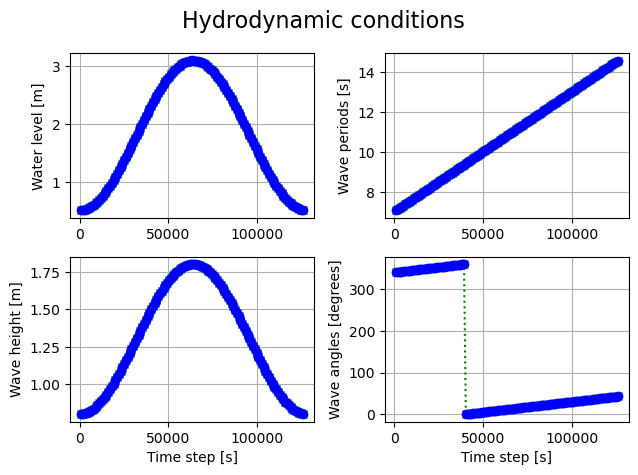

In [260]:
deviz.plot_hydrodynamic_conditions(input)
plt.show()

## Visualize failure and damage levels
The toolbox contains multiple functions to visualize information. To plot failure for each location and the development of damage levels, we can use the following function.

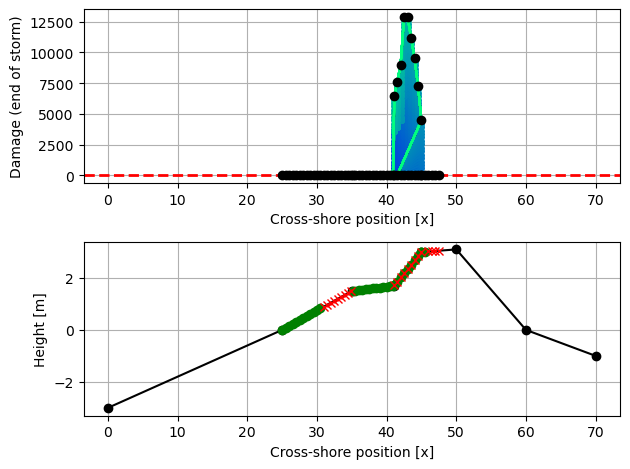

In [261]:
deviz.plot_damage_levels(output, input)
plt.show()

There is also a standard function available to plot the development of a specific output variable in time. This function uses a value of the TimeDependentOutputQuantity class to specify which information should be shown.

In [262]:
from dikerosion.data import TimeDependentOutputQuantity

Once this class is known, we can specify which output variable needs to be visualized. The function then plots the development of this variable for all output locations.

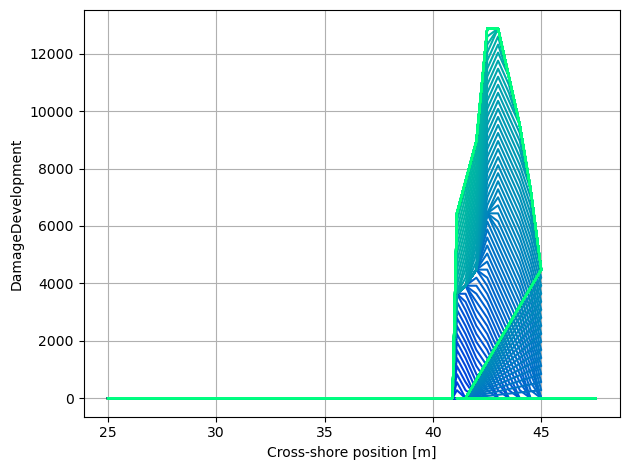

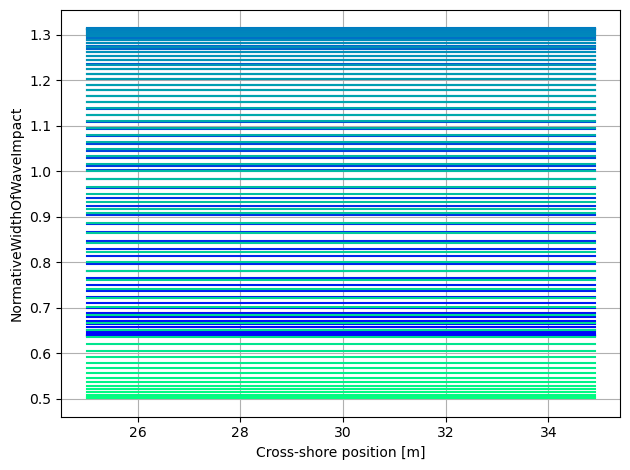

In [263]:
deviz.plot_development(output, TimeDependentOutputQuantity.DamageDevelopment, input)
natural_stone_locations = [o for o in output if o.calculation_method == CalculationMethod.NaturalStone] 
deviz.plot_development(natural_stone_locations, TimeDependentOutputQuantity.NormativeWidthOfWaveImpact, input)

plt.show()